In [43]:
import h5py
import torch
import sklearn.calibration as sc
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import math
from skimage.color import label2rgb
from typing import  Union,Sequence
from atommic.collections.segmentation.losses.dice import Dice,one_hot
from scipy.spatial.distance import directed_hausdorff

In [44]:
# Function for plotting MRI scans



def get_scaled_image(
    x: Union[torch.Tensor, np.ndarray], percentile=0.99, clip=False
):
  """Scales image by intensity percentile (and optionally clips to [0, 1]).

  Args:
    x (torch.Tensor | np.ndarray): The image to process.
    percentile (float): The percentile of magnitude to scale by.
    clip (bool): If True, clip values between [0, 1]

  Returns:
    torch.Tensor | np.ndarray: The scaled image.
  """
  is_numpy = isinstance(x, np.ndarray)
  if is_numpy:
    x = torch.as_tensor(x)

  scale_factor = torch.quantile(x, percentile)
  x = x / scale_factor
  if clip:
    x = torch.clip(x, 0, 1)

  if is_numpy:
    x = x.numpy()

  return x


def plot_images(
    images, processor=None, disable_ticks=True, titles: Sequence[str]=None,
    ylabel: str=None, xlabels: Sequence[str]=None, cmap: str="gray",
    show_cbar: bool = False, overlay = None, opacity: float = 0.3,
    hsize=5, wsize=5, axs=None,fontsize =20
):
  """Plot multiple images in a single row.

  Add an overlay with the `overlay=` argument.
  Add a colorbar with `show_cbar=True`.
  """
  def get_default_values(x, default=""):
    if x is None:
      return [default] * len(images)
    return x

  titles = get_default_values(titles)
  ylabels = get_default_values(images)
  xlabels = get_default_values(xlabels)

  N = len(images)
  if axs is None:
    fig, axs = plt.subplots(1, N, figsize=(wsize * N, hsize))
  else:
    assert len(axs) >= N
    fig = axs.flatten()[0].get_figure()
  k = 0
  for ax, img, title, xlabel in zip(axs, images, titles, xlabels):
    if processor is not None:
      img = processor(img)
    if type(cmap)==list:
        im = ax.imshow(img, cmap=cmap[k])
        if type(show_cbar)==list:
            if show_cbar[k]:
                fig.subplots_adjust(bottom=0.2)
                cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
                fig.colorbar(im, cax=cbar_ax)
    else:
      im = ax.imshow(img, cmap=cmap)
    k = k+1
    ax.set_title(title,fontsize=fontsize)
    ax.set_xlabel(xlabel)


  if type(overlay) ==list:
    for i,ax in enumerate(axs.flatten()):
      if overlay[i] is not None:
        im = ax.imshow(overlay[i], alpha=opacity)


  if disable_ticks:
    for ax in axs.flatten():
      ax.get_xaxis().set_ticks([])
      ax.get_yaxis().set_ticks([])

  return axs


In [45]:
def dice_metric(
    x: torch.Tensor,
    y: torch.Tensor,
    include_background: bool = False,
    to_onehot_y: bool = False,
    sigmoid: bool = False,
    softmax: bool = False,
    other_act: Union[str, None] = None,
    squared_y: bool = False,
    jaccard: bool = False,
    flatten: bool = False,
    reduction: Union[str, None] = "mean_batch",
    smooth_nr: float = 1e-5,
    smooth_dr: float = 1e-5,
    batch: bool = True,
) -> float:
    """Compute Dice Score.

    Parameters
    ----------
    x : torch.Tensor
        Ground Truth Tensor.
    y : torch.Tensor
        Prediction Tensor.
    include_background : bool
        Whether to skip Dice computation on the first channel of the predicted output. Default is ``True``.
    to_onehot_y : bool
        Whether to convert `y` into the one-hot format. Default is ``False``.
    sigmoid : bool
        Whether to add sigmoid function to the input data. Default is ``True``.
    softmax : bool
        Whether to add softmax function to the input data. Default is ``False``.
    other_act : Union[str, None]
        Use this parameter if you want to apply another type of activation layer. Default is ``None``.
    squared_y : bool
        Whether to square the prediction before calculating Dice. Default is ``False``.
    jaccard : bool
        Whether to compute Jaccard Index as a loss. Default is ``False``.
    flatten : bool
        Whether to flatten input data. Default is ``False``.
    reduction : Union[str, None]
        Specifies the reduction to apply to the output: ``none`` | ``mean`` | ``sum``.
        ``none``: no reduction will be applied. ``mean``: the sum of the output will be divided by the number of
        elements. ``sum``: the output will be summed. Default is ``mean``.
    smooth_nr : float
        A small constant added to the numerator to avoid ``nan`` when all items are 0.
    smooth_dr : float
        A small constant added to the denominator to avoid ``nan`` when all items are 0.
    batch : bool
        If True, compute Dice loss for each batch and return a tensor with shape (batch_size,).
        If False, compute Dice loss for the whole batch and return a tensor with shape (1,).
        Default is ``True``.
    Returns
    -------
    float
        Dice Score.

    Examples
    --------
    >>> from atommic.collections.segmentation.metrics.segmentation_metrics import dice_metric
    >>> import torch
    >>> datax = torch.randint(0, 2, (3, 2, 100, 100))
    >>> datay = torch.randint(0, 2, (3, 2, 100, 100))
    >>> dice_metric(datax, datay)
    0.5016108751296997
    """
    custom_dice = Dice(
        include_background=include_background,
        to_onehot_y=to_onehot_y,
        sigmoid=sigmoid,
        softmax=softmax,
        other_act=other_act,  # type: ignore
        squared_pred=squared_y,
        jaccard=jaccard,
        flatten=flatten,
        reduction=reduction,  # type: ignore
        smooth_nr=smooth_nr,
        smooth_dr=smooth_dr,
        batch=batch,
    )
    print(x.shape,y.shape)
    dice_score, _ = custom_dice(x, y)
    return dice_score.item()

In [46]:
def hausdorff_distance_metric(x: torch.Tensor, y: torch.Tensor, batched: bool = True, sum_method='max') -> float:
    """Compute Hausdorff Distance.

    The Hausdorff distance is computed as the maximum between x to y and y to x.

    Parameters
    ----------
    x : torch.Tensor
        Ground Truth Tensor.
    y : torch.Tensor
        Prediction Tensor.
    batched : bool
        If True, compute Hausdorff distance for each batch and return a tensor with shape (batch_size,).
        If False, compute Hausdorff distance for the whole batch and return a tensor with shape (1,).
        Default is ``True``.
    sum_method : str
        Method to sum the 95th percentile of the Hausdorff Distance. Default is ``max``, which argmax the 95th
        percentile of the Hausdorff Distance. If ``sum``, sum the 95th percentile of the Hausdorff Distance.

    Returns
    -------
    float
        Hausdorff Distance.

    Examples
    --------
    >>> from atommic.collections.segmentation.metrics.segmentation_metrics import hausdorff_distance_metric
    >>> import torch
    >>> datax = torch.randint(0, 2, (3, 2, 100, 100))
    >>> datay = torch.randint(0, 2, (3, 2, 100, 100))
    >>> hausdorff_distance_metric(datax, datay)
    5.858907404245753
    """
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    if isinstance(y, np.ndarray):
        y = torch.from_numpy(y)
    if batched:
        hd = []
        for sl in range(x.shape[0]):
            hdx = x[sl].float().argmax(0).numpy() if sum_method == 'max' else x[sl].float().sum(0).numpy()
            hdy = y[sl].float().argmax(0).numpy() if sum_method == 'max' else y[sl].float().sum(0).numpy()
            hd.append(max(directed_hausdorff(hdx, hdy)[0], directed_hausdorff(hdy, hdx)[0]))
        return sum(hd) / len(hd)

    x = x.float().argmax(0).numpy() if sum_method == 'max' else x.float().sum(0).numpy()
    y = y.float().argmax(0).numpy() if sum_method == 'max' else y.float().sum(0).numpy()
    return max(directed_hausdorff(x, y)[0], directed_hausdorff(y, x)[0])


def complex_abs(x: torch.Tensor) -> torch.Tensor:
    """
    Compute the absolute value of a complex valued input tensor.

    Parameters
    ----------
    x : torch.Tensor
        Complex tensor. The last dimension must be of size 2.

    Returns
    -------
    torch.Tensor
        Absolute value of complex tensor.

    Examples
    --------
    >>> from atommic.collections.common.parts.utils import complex_abs
    >>> import torch
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> complex_abs(data)
    tensor([1.4142, 2.8284, 4.2426])
    """
    if x.shape[-1] != 2:
        if torch.is_complex(x):
            x = torch.view_as_real(x)
        else:
            raise ValueError("Tensor does not have separate complex dim.")
    return (x ** 2).sum(dim=-1)

In [47]:

fname = '/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/temperature/2024-03-14_21-52-14/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    segmentations_mtlrs_1  = f['segmentation'][()].squeeze()
    segmentation_labels_org_1  = f['target_segmentation'][()].squeeze()
fname = '/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/temperature/2024-03-20_20-47-37/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    segmentations_mtlrs_2  = f['segmentation'][()].squeeze()
    segmentation_labels_org_2  = f['target_segmentation'][()].squeeze()
#scan_mtlrs = inter_rec[:,0,...]
print(segmentation_labels_org_1.shape,segmentations_mtlrs_1.shape,segmentations_mtlrs_1.shape,segmentation_labels_org_2.shape)
print(segmentations_mtlrs_1[10,:,10,10])
print(segmentations_mtlrs_2[10,:,10,10])


<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>
(80, 5, 256, 208) (80, 5, 256, 208) (80, 5, 256, 208) (80, 5, 256, 208)
[14.7734375   0.13476562  0.1159668   0.26416016  0.328125  ]
[31.734375    0.1430664   0.06445312  0.06494141  0.1451416 ]


In [48]:



segmentations_mtlrs_soft_1 = torch.softmax(torch.from_numpy(segmentations_mtlrs_1)/5,dim=1).numpy()
prob_true_bg, prob_pred_bg = sc.calibration_curve(segmentation_labels_org_1[:,0].reshape(-1),segmentations_mtlrs_soft_1[:,0].reshape(-1),n_bins=10)
prob_true_1, prob_pred_1 = sc.calibration_curve(segmentation_labels_org_1[:,1].reshape(-1),segmentations_mtlrs_soft_1[:,1].reshape(-1),n_bins=10)
prob_true_2, prob_pred_2 = sc.calibration_curve(segmentation_labels_org_1[:,2].reshape(-1),segmentations_mtlrs_soft_1[:,2].reshape(-1),n_bins=10)
prob_true_3, prob_pred_3 = sc.calibration_curve(segmentation_labels_org_1[:,3].reshape(-1),segmentations_mtlrs_soft_1[:,3].reshape(-1),n_bins=10)
prob_true_4, prob_pred_4 = sc.calibration_curve(segmentation_labels_org_1[:,4].reshape(-1),segmentations_mtlrs_soft_1[:,4].reshape(-1),n_bins=10)



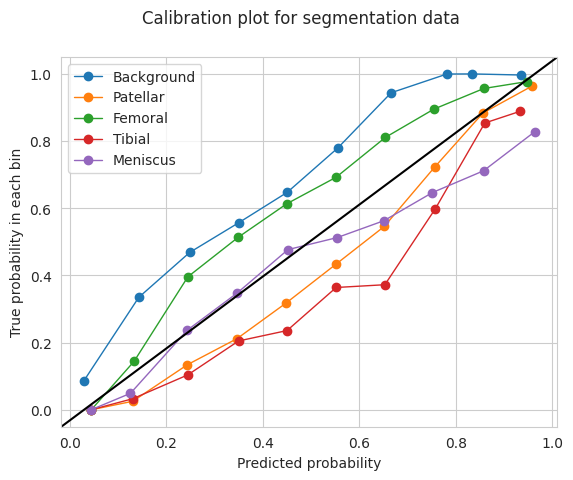

In [49]:


fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(prob_pred_bg,prob_true_bg, marker='o', linewidth=1, label='Background')
plt.plot(prob_pred_1,prob_true_1, marker='o', linewidth=1, label='Patellar')
plt.plot(prob_pred_2,prob_true_2, marker='o', linewidth=1, label='Femoral')
plt.plot(prob_pred_3,prob_true_3, marker='o', linewidth=1, label='Tibial')
plt.plot(prob_pred_4,prob_true_4, marker='o', linewidth=1, label='Meniscus')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for segmentation data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()



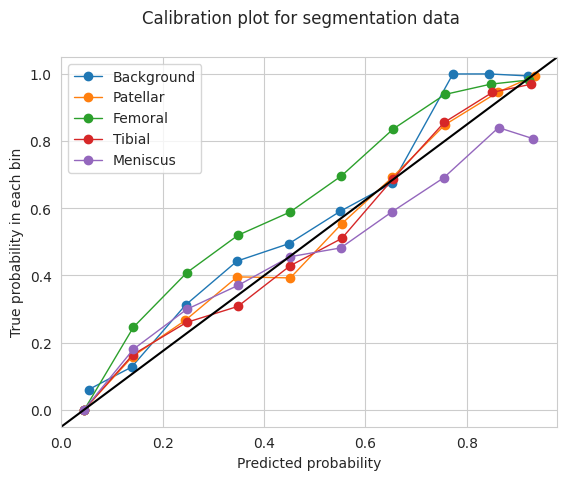

In [62]:
segmentations_mtlrs_soft_2 = torch.softmax(torch.from_numpy(segmentations_mtlrs_2)/10, dim=1).numpy()
prob_true_bg, prob_pred_bg = sc.calibration_curve(segmentation_labels_org_2[:, 0].reshape(-1),
                                                  segmentations_mtlrs_soft_2[:, 0].reshape(-1), n_bins=10)
prob_true_1, prob_pred_1 = sc.calibration_curve(segmentation_labels_org_2[:, 1].reshape(-1),
                                                segmentations_mtlrs_soft_2[:, 1].reshape(-1), n_bins=10)
prob_true_2, prob_pred_2 = sc.calibration_curve(segmentation_labels_org_2[:, 2].reshape(-1),
                                                segmentations_mtlrs_soft_2[:, 2].reshape(-1), n_bins=10)
prob_true_3, prob_pred_3 = sc.calibration_curve(segmentation_labels_org_2[:, 3].reshape(-1),
                                                segmentations_mtlrs_soft_2[:, 3].reshape(-1), n_bins=10)
prob_true_4, prob_pred_4 = sc.calibration_curve(segmentation_labels_org_2[:, 4].reshape(-1),
                                                segmentations_mtlrs_soft_2[:, 4].reshape(-1), n_bins=10)

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(prob_pred_bg, prob_true_bg, marker='o', linewidth=1, label='Background')
plt.plot(prob_pred_1, prob_true_1, marker='o', linewidth=1, label='Patellar')
plt.plot(prob_pred_2, prob_true_2, marker='o', linewidth=1, label='Femoral')
plt.plot(prob_pred_3, prob_true_3, marker='o', linewidth=1, label='Tibial')
plt.plot(prob_pred_4, prob_true_4, marker='o', linewidth=1, label='Meniscus')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for segmentation data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show()

(80, 5, 256, 208) (80, 5, 256, 208)
(80, 5, 256, 208) (80, 5, 256, 208)
Dimitris MTL Dice : 0.8417221307754517
Tim MTL DIce : 0.8646330237388611
Dimitris MTL HD : 9.433491165392688
Tim MTL  HD : 7.101169890055014


array([<Axes: title={'center': 'Target'}>,
       <Axes: title={'center': 'Predicted Segmentation Dimitris MTL'}>,
       <Axes: title={'center': 'Predicted Segmentation Tim MTL'}>],
      dtype=object)

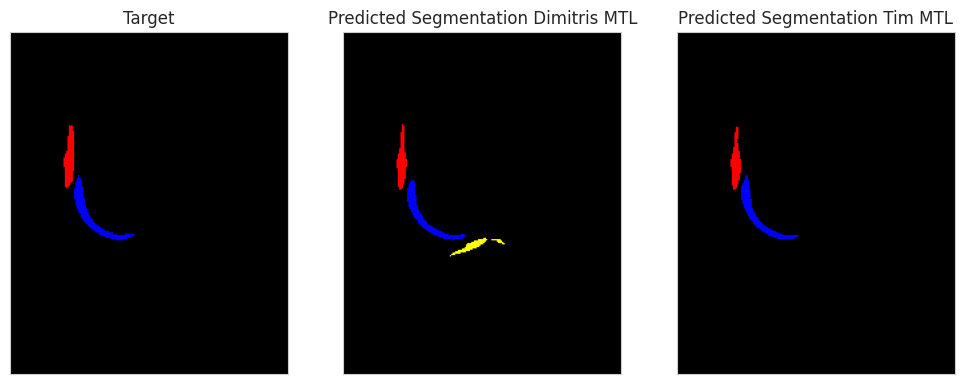

In [63]:
sl=40
pred_seg_1 = label2rgb(np.argmax(segmentations_mtlrs_soft_1[sl, :, :, :],axis=0), bg_label=0)
pred_seg_2 = label2rgb(np.argmax(segmentations_mtlrs_soft_2[sl, :, :, :],axis=0), bg_label=0)
tar_seg = label2rgb(np.argmax(segmentation_labels_org_1[sl, :, :, :],axis=0), bg_label=0)


segmentations_mtlrs_1_def = one_hot(torch.argmax(torch.abs(torch.from_numpy(segmentations_mtlrs_soft_1[:, :, :, :])),dim=1).unsqueeze(1),num_classes=segmentations_mtlrs_soft_1.shape[1]).float().numpy()
segmentations_mtlrs_2_def = one_hot(torch.argmax(torch.abs(torch.from_numpy(segmentations_mtlrs_soft_2[:, :, :, :])),dim=1).unsqueeze(1),num_classes=segmentations_mtlrs_soft_2.shape[1]).float().numpy()
dice_1=dice_metric(segmentation_labels_org_1,segmentations_mtlrs_1_def)
dice_2=dice_metric(segmentation_labels_org_2,segmentations_mtlrs_2_def)
hd_1=hausdorff_distance_metric(segmentation_labels_org_1,segmentations_mtlrs_1_def)
hd_2=hausdorff_distance_metric(segmentation_labels_org_1,segmentations_mtlrs_2_def)
hsize = 5
wsize = hsize / segmentations_mtlrs_1.shape[-2] * segmentations_mtlrs_1.shape[-1]
print(f"Dimitris MTL Dice : {dice_1}")
print(f"Tim MTL DIce : {dice_2}")
print(f"Dimitris MTL HD : {hd_1}")
print(f"Tim MTL  HD : {hd_2}")

plot_images([tar_seg, pred_seg_1,pred_seg_2], titles=['Target', "Predicted Segmentation Dimitris MTL","Predicted Segmentation Tim MTL","Predicted Segmentation Joint"], fontsize=12, wsize=wsize, hsize=hsize)